In [1]:
# feature extractoring and preprocessing data
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from pathlib import Path
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Reports
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'Energy')

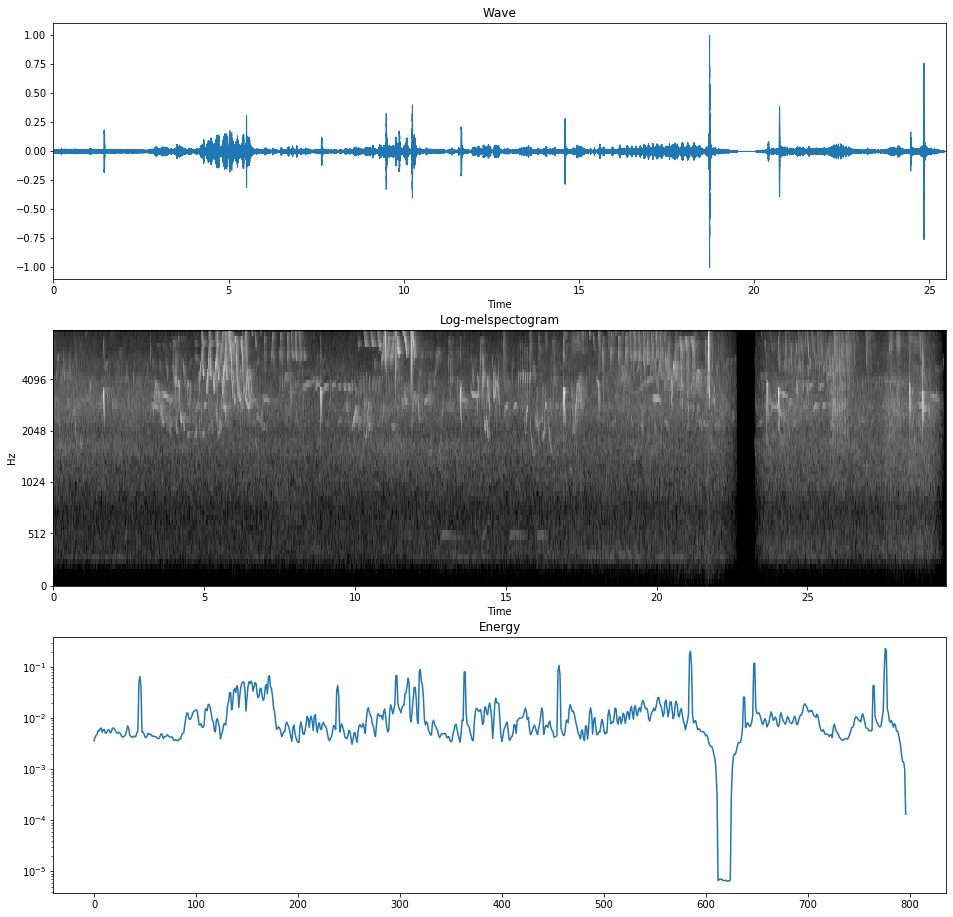

In [4]:
sr=16000
n_mels = 64
cmap = plt.get_cmap('gray')

e_file = 'train_audio/aldfly/XC134874.mp3'#XC167210.mp3 XC124067.mp3

y, sr = librosa.load(e_file, mono=True, sr=sr)#duration=5
y = librosa.util.normalize(y, axis=0)
D = np.abs(librosa.stft(y, n_fft=int(0.040*sr),
                                hop_length=int(0.020*sr),
                                window='hann'))**2
S = librosa.feature.melspectrogram(S=D,sr=sr, n_mels=64)
plt.figure(figsize=(16,16))
sub = plt.subplot(3,1,1)
librosa.display.waveplot(y,sr=sr, x_axis='time')
sub.set_title('Wave')
sub2 = plt.subplot(3,1,2)
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                                 y_axis='mel', fmax=8000,
                                 x_axis='time',
                                 cmap = cmap)
sub2.set_title('Log-melspectogram')
sub3 = plt.subplot(3,1,3)
rms = librosa.feature.rms(y=y,frame_length=1024, hop_length=512)
plt.semilogy(rms.T)
sub3.set_title('Energy')

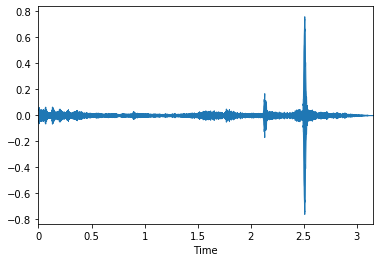

In [5]:
sr=16000
n_mels = 64

def max_5s(file, sr):
    #open file
    y, sr = librosa.load(file, mono=True, sr=sr)
    y = librosa.util.normalize(y, axis=0)
    # if audio < 5s, append and cut
    if len(y) < 5*sr:
        for i in range(int(0.5+5*sr/len(y))):
            y = np.append(y,y)
        return y[:5*sr] #nothing more to do
    # get max energy point
    rms = librosa.feature.rms(y=y,frame_length=1024, hop_length=512)
    me = np.argmax(rms)*512
    # Check bounds (for audios >= 5s only)
    if me > 2.5*sr:
        if len(y) < me+2.5*sr: # check for upper bound
            y5 = y[int(me-2.5*sr):int(me+2.5*sr)] #2.5 seg before and 2.5 after
        else:
            y5 = y[len(y)-5*sr:len(y)] # get the last 5 s
    else:
        y5 = y[:5*sr] # get the first 5 s
    return y5

y = max_5s(e_file, sr)
librosa.display.waveplot(y,sr=sr, x_axis='time')

In [6]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21375 entries, 0 to 21374
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            21375 non-null  float64
 1   playback_used     19575 non-null  object 
 2   ebird_code        21375 non-null  object 
 3   channels          21375 non-null  object 
 4   date              21375 non-null  object 
 5   pitch             21375 non-null  object 
 6   duration          21375 non-null  int64  
 7   filename          21375 non-null  object 
 8   speed             21375 non-null  object 
 9   species           21375 non-null  object 
 10  number_of_notes   21375 non-null  object 
 11  title             21375 non-null  object 
 12  secondary_labels  21375 non-null  object 
 13  bird_seen         19575 non-null  object 
 14  sci_name          21375 non-null  object 
 15  location          21375 non-null  object 
 16  latitude          21375 non-null  object

In [7]:
# Selecting high-rated sound only
dff = df[df['rating'] > 4.0]
# Selecting shorter files only, less data to process
dff = dff[dff['duration'] < 20]
print(len(dff))

2497


In [8]:
# Selecting birds with more than 10 examples left
dfc = dff.groupby('ebird_code')['ebird_code'].count()
dff = dff[~dff['ebird_code'].isin(dfc[dfc.values < 10].index)]
print(len(dff))

1781


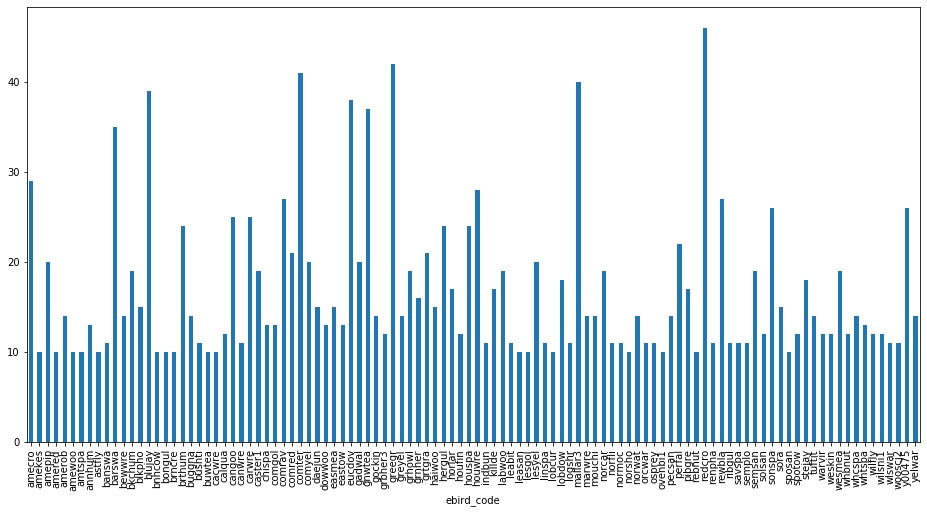

In [9]:
# Not all classes may be represented according to filtering
# Several classes decreased a lot
dfc = dff.groupby('ebird_code')['ebird_code'].count()
plt.figure(figsize=(16,8))
dfc.plot.bar()

In [10]:
audio_path = Path('train_audio')

sound_categories = dff['ebird_code'].unique()

audios = []
Y = []
Y_classes = []
label = 0
for category_name in sound_categories:
    #Walk through the dataframe filename values
    l_files = dff[dff['ebird_code'] == category_name]['filename'].values
    for file_name in l_files:
        try:
            sound_path = audio_path/category_name/file_name
            y = max_5s(sound_path, sr)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mels)
            to_append = ''
            for e in mfcc:
                to_append += f' {np.mean(e)} {np.std(e)}'
            S = np.fromstring(to_append, dtype=float, sep=" ")
            audios.append(S)
            Y.append(label)
            Y_classes.append(category_name)
        except:
            print(sound_path)
            pass
    label +=1
    if label == 20:
        break
X = np.array(audios)
Y = np.array(Y)
num_classes = len(sound_categories)

In [11]:
perc_test = 0.2

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=perc_test)
print(x_train.shape)
print(x_test.shape)

(261, 128)
(66, 128)
